In [2]:
import sys
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../src/")
from Network_Validator_Main import main

DTALite, version 0.8.1



In [2]:
%run ../src/Network_Validator_Main.py

Subdirectories:
../data/
GMNS Network Validator
Working directory: ../data/
Using node file: ../data/node.csv
Using link file: ../data/link.csv
Using demand file: ../data/demand.csv
Validation level: 7

Running validation at Readiness Level 7...

SUCCESS: Zone centroids are correctly listed in non-decreasing order at the beginning of the file

First through node identified as node_id=235

Found 234 zone centroids out of 8521 total nodes

First through node identified as node_id=235

Found 235 unique zone IDs in node file
Found 234 unique zone IDs in demand file

SUCCESS: All zones in demand file exist in node file
Copied settings.csv and NEXTA.exe to ../data


KeyboardInterrupt: 

In [3]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

In [4]:
# Read the CSV file into a DataFrame
df_demand = pd.read_csv('../data/demand.csv')
df_link = pd.read_csv('../data/link.csv')
df_node = pd.read_csv('../data/node.csv')
df_google_maps_od_distance = pd.read_csv('../data/google_maps_od_distance.csv')
df_inaccessible_od = pd.read_csv('../data/inaccessible_od.csv')
df_destination_accessibility = pd.read_csv('../data/destination_accessibility.csv')
df_link_performance = pd.read_csv('../data/link_performance.csv')
df_od_performance = pd.read_csv('../data/od_performance.csv')
df_origin_accessibility = pd.read_csv('../data/origin_accessibility.csv')
df_problem_volume_links = pd.read_csv('../data/problem_volume_links.csv')
df_problematic_od_distances = pd.read_csv('../data/problematic_od_distances.csv')
df_route_assignment = pd.read_csv('../data/route_assignment.csv')
df_sample_mode_type = pd.read_csv('../data/sample_mode_type.csv')
df_sample_settings = pd.read_csv('../data/sample_settings.csv')
df_settings = pd.read_csv('../data/settings.csv')
df_system_performance = pd.read_csv('../data/system_performance.csv')
df_TAP_log = pd.read_csv('../data/TAP_log.csv')


In [5]:
from shapely import wkt

# 1. Chargement des CSV
df_nodes = df_node.copy()
df_links = df_link.copy()


# 2. Conversion de la colonne texte 'geometry' en objets géométriques réels
# C'est l'étape clé : on transforme le texte "POINT(..)" en objet Point()
df_nodes['geometry'] = df_nodes['geometry'].apply(wkt.loads)
df_links['geometry'] = df_links['geometry'].apply(wkt.loads)

# 3. Création des GeoDataFrames
gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry='geometry', crs="epsg:4326")
gdf_links = gpd.GeoDataFrame(df_links, geometry='geometry', crs="epsg:4326")
# On définit l'ID comme index (plus rapide pour NetworkX)
gdf_nodes.set_index('node_id', inplace=True)
gdf_links.set_index('link_id', inplace=True)

print("Données chargées et géométries reconnues !")
gdf_links.head()


Données chargées et géométries reconnues !


,name,from_node_id,to_node_id,facility_type,link_type,dir_flag,cell_type,length,lanes,free_speed,...,vdf_free_speed_mph,vdf_fftt,vdf_toll,vdf_alpha,vdf_beta,vdf_plf,ref_volume,obs_volume,Unnamed: 22,Unnamed: 23
link_id,,,,,,,,,,,,,,,,,,,,,
25311,NaN,1,1185,NaN,0,1,-1,153.94179,1,15.0,...,9.320568,0.0,0,0.5,1.5,1,0.0,0,NaN,NaN
25578,NaN,1,1186,NaN,0,1,-1,153.94179,1,15.0,...,9.320568,0.0,0,0.5,1.5,1,0.0,0,NaN,NaN
25313,NaN,1,1187,NaN,0,1,-1,153.94179,1,15.0,...,9.320568,0.0,0,0.5,1.5,1,0.0,0,NaN,NaN
25580,NaN,1,1427,NaN,0,1,-1,153.94179,1,15.0,...,9.320568,0.0,0,0.5,1.5,1,0.0,0,NaN,NaN
25582,NaN,1,1428,NaN,0,1,-1,153.94179,1,15.0,...,9.320568,0.0,0,0.5,1.5,1,0.0,0,NaN,NaN


Graphe NetworkX créé avec 8521 nœuds et 30747 arêtes.


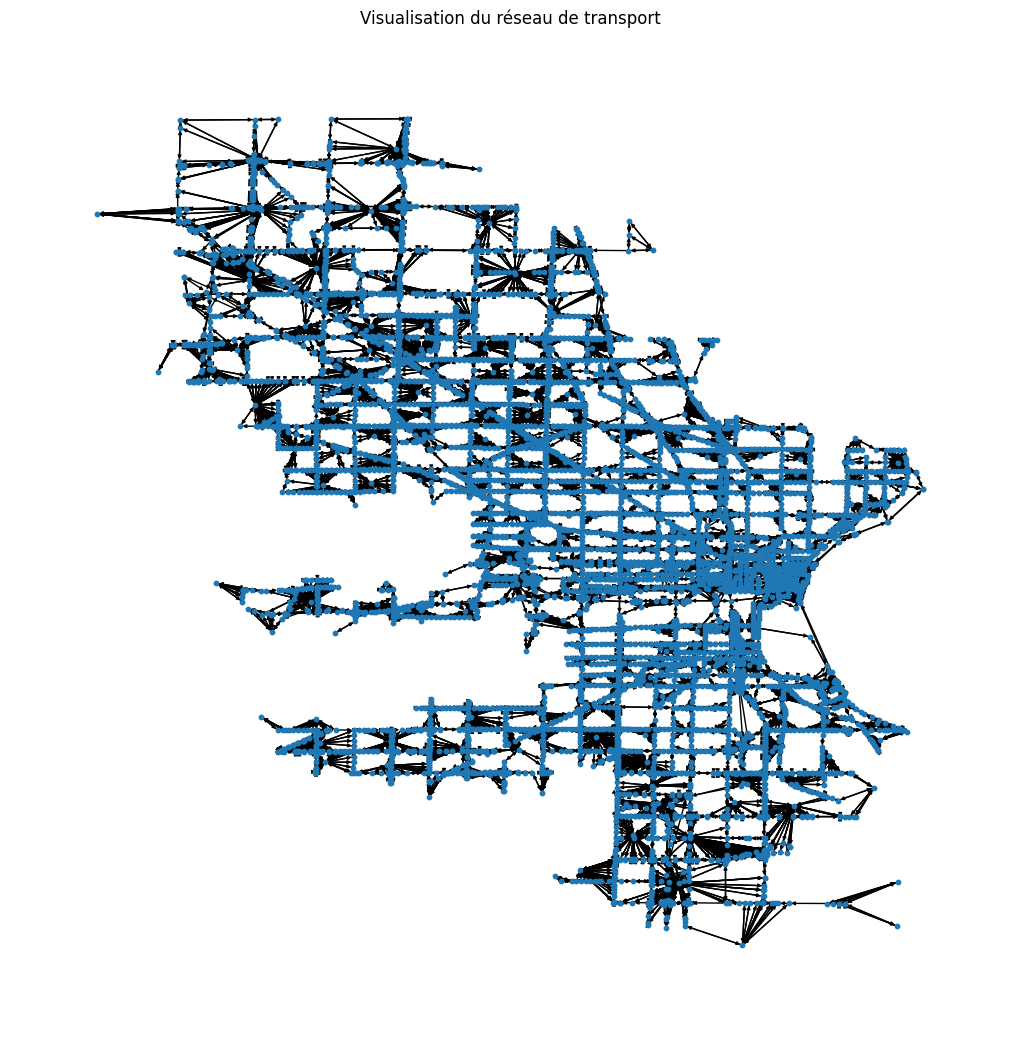

In [ ]:
 #4. Création du graphe NetworkX
G = nx.DiGraph()
for idx, row in gdf_nodes.iterrows():
    G.add_node(idx, geometry=row['geometry'], **row.drop('geometry').to_dict())
for idx, row in gdf_links.iterrows():
    start_node = row['from_node_id']
    end_node = row['to_node_id']
    G.add_edge(start_node, end_node, geometry=row['geometry'], **row.drop(['geometry', 'from_node_id', 'to_node_id']).to_dict())
print("Graphe NetworkX créé avec {} nœuds et {} arêtes.".format(G.number_of_nodes(), G.number_of_edges()))
# 5. Visualisation simple
plt.figure(figsize=(10, 10))
pos = {node: (data['geometry'].x, data['geometry'].y) for node, data in G.nodes(data=True)}
nx.draw(G, pos, node_size=10, arrowsize=5)
plt.title("Visualisation du réseau de transport")
plt.show()

In [6]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================

DATA_DIR = '../data/'
RANDOM_SEED = 42

VOT = 15.0
CO2_PRICE = 100.0
DISCOUNT_RATE = 0.04
HORIZON = 30
ANNUALIZATION = 250 * 2 # working days * round trips per day (this is a simplification)
THETA = 0.1
EMISSION_FACTOR = 150 # gCO2 per vehicle-km (simplified average)
DECAY_BIKE = 0.15
DECAY_CAR = 0.08
ASSIGNMENT_ITER = 1 # should be increased for more accurate results
DEMAND_FACTOR = 5
MAINT_RATE = 0.01

PARAMS = {
    'vot': VOT, 'co2_price': CO2_PRICE, 'discount_rate': DISCOUNT_RATE,
    'horizon': HORIZON, 'annualization': ANNUALIZATION, 'theta': THETA,
    'emission_factor': EMISSION_FACTOR, 'decay_bike': DECAY_BIKE,
    'decay_car': DECAY_CAR, 'assignment_iter': ASSIGNMENT_ITER
}

BUDGET = 15_000_000
PENALTY_FACTOR = 1e6 # penalty for exceeding budget in optimization (lambda)

MCA_WEIGHTS = {
    'npv': 0.30, 'co2': 0.25,
    'bike_accessibility': 0.125, 'car_accessibility': 0.125,
    'bike_equity': 0.10, 'car_equity': 0.10
}

N_BIKE_PROJECTS = 30
N_CAR_PROJECTS = 5
BIKE_UPGRADE_COST = 500_000
CAR_EXPAND_COST = 2_000_000
CANDIDATE_METHOD = 'flow'

# quick test settings (increase for real runs but expect long runtimes)
GA_POP = 4
GA_GEN = 4
NSGA_POP = 4
NSGA_GEN = 4

## just enough to see some optimization progress (will take longer but still manageable):
# GA_POP = 10
# GA_GEN = 10
# NSGA_POP = 10
# NSGA_GEN = 10

# # more sensible defaults for real runs (will take much longer):
# GA_POP = 20
# GA_GEN = 30
# NSGA_POP = 50
# NSGA_GEN = 50

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import utils_accessibility as ua  # Votre module

# 1. Chargement des données


# --- PRÉPARATION DU SKIM MATRIX (Coûts de transport) ---
# On sélectionne les colonnes pertinentes pour l'accessibilité
# On utilisera le temps de trajet en congestion (plus réaliste)
skim_df = df_od_performance[['o_zone_id', 'd_zone_id', 'total_congestion_travel_time']].copy()
skim_df.columns = ['origin', 'destination', 'cost']  # Renommage pour matcher vos fonctions

# --- PRÉPARATION DES OPPORTUNITÉS (Attractivité des zones) ---
# Ici, on utilise le volume total *attiré* par chaque zone comme proxy de son attractivité
# (Alternative : utiliser l'emploi ou la population si vous avez ces données ailleurs)
opportunity_df = df_demand.groupby('d_zone_id')['volume'].sum().reset_index()
opportunity_df.columns = ['zone_id', 'opportunities']



In [8]:
# 1. Accessibilité Contour (Seuil de 30 minutes)
acc_contour = ua.calculate_contour_accessibility(
    skim_df=skim_df,
    opportunity_df=opportunity_df,
    threshold_T=30,  # 30 minutes
    verbose=True
)

# 2. Accessibilité Gravitaire (Beta = 0.1, standard pour l'urbain)
acc_gravity = ua.calculate_gravity_accessibility(
    skim_df=skim_df,
    opportunity_df=opportunity_df,
    decay_beta=0.1,
    verbose=True
)

# 3. Calcul de l'inégalité spatiale (Coefficient de Gini)
gini_contour = ua.calculate_gini_coefficient(acc_contour)
gini_gravity = ua.calculate_gini_coefficient(acc_gravity)

print(f"Coefficient de Gini (Contour 30min) : {gini_contour:.4f}")
print(f"Coefficient de Gini (Gravité)       : {gini_gravity:.4f}")

  Calculating Contour Accessibility (Threshold T = 30 min)...
  Calculating Gravity Accessibility (Decay Beta = 0.1)...
Coefficient de Gini (Contour 30min) : 0.0787
Coefficient de Gini (Gravité)       : 0.1863


In [9]:
# --- KPI 1 : Indice de Détour (Efficiency) ---
# On compare la distance réelle parcourue vs la ligne droite
df_od_performance['detour_index'] = df_od_performance['total_distance_km'] / df_od_performance['straight_line_distance_km']
avg_detour = df_od_performance['detour_index'].mean()

# --- KPI 2 : Indice de Congestion (Reliability) ---
# Ratio Temps Congestionné / Temps Flux Libre
df_od_performance['congestion_index'] = df_od_performance['total_congestion_travel_time'] / df_od_performance['total_free_flow_travel_time']
# On pondère par le volume pour avoir une moyenne ressentie par les usagers
weighted_congestion = (df_od_performance['congestion_index'] * df_od_performance['volume']).sum() / df_od_performance['volume'].sum()

print(f"Indice de Détour Moyen      : {avg_detour:.2f} (1.0 = ligne droite)")
print(f"Indice de Congestion Pondéré: {weighted_congestion:.2f} (1.0 = fluide)")

Indice de Détour Moyen      : 1.07 (1.0 = ligne droite)
Indice de Congestion Pondéré: 1.40 (1.0 = fluide)


Correction appliquée. PROJ_LIB pointe vers : c:\Users\celes\miniconda3\envs\GMNS_Plus_Dataset\Library\share\proj

  Plotting Auto Gravity Accessibility map with basemap...


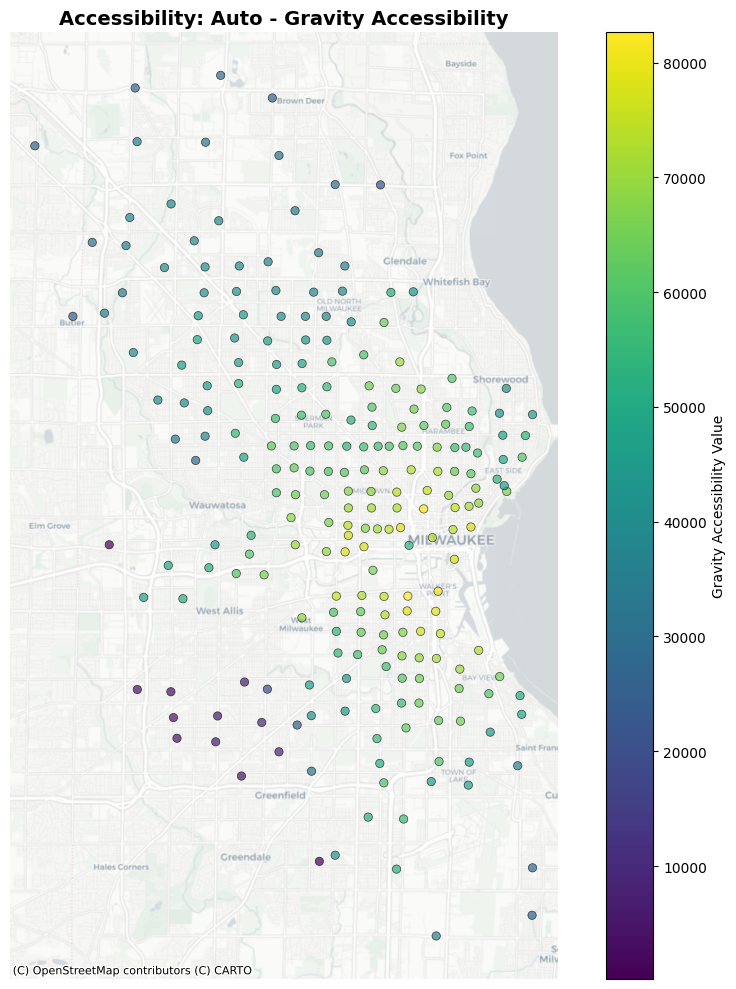

In [10]:
from shapely.geometry import Point
import utils_accessibility as ua  # Votre module
import os
import sys

# 1. On récupère le chemin de votre environnement Conda actuel
conda_env_path = sys.prefix

# 2. On construit le chemin vers le dossier 'proj' (spécifique à Windows)
# Ce dossier contient le fameux 'proj.db' manquant
proj_lib_path = os.path.join(conda_env_path, 'Library', 'share', 'proj')

# 3. On force la variable d'environnement AVANT d'importer geopandas
os.environ['PROJ_LIB'] = proj_lib_path

print(f"Correction appliquée. PROJ_LIB pointe vers : {proj_lib_path}")


# Création d'un GeoDataFrame temporaire pour les centres des zones
zones_coords = df_od_performance[['o_zone_id', 'o_x_coord', 'o_y_coord']].drop_duplicates()
geometry = [Point(xy) for xy in zip(zones_coords.o_x_coord, zones_coords.o_y_coord)]
zones_gdf = gpd.GeoDataFrame(zones_coords, geometry=geometry, crs="EPSG:4326")
zones_gdf.rename(columns={'o_zone_id': 'id'}, inplace=True)

# Note : Pour une vraie carte choroplèthe (zones pleines), il faudrait créer des polygones de Voronoi
# ou charger le vrai Shapefile des zones. Ici, nous aurons des points.

# Visualisation avec votre fonction utilitaire
fig1, ax1 = ua.plot_accessibility_map_with_basemap(
    zones_gdf=zones_gdf,
    accessibility_series=acc_gravity,
    mode_name="Auto",
    measure_name="Gravity Accessibility",
    color_map="viridis", # Viridis est souvent plus lisible que PiYG pour des échelles positives
    verbose=True
)

plt.show()